# STDSR - Assignment 1

Student: **Trang Nguyen**

Group: **BS18-DS01**

Method: Lin n-of-N

## Implement Lin n-of-N

**Construct sketch**

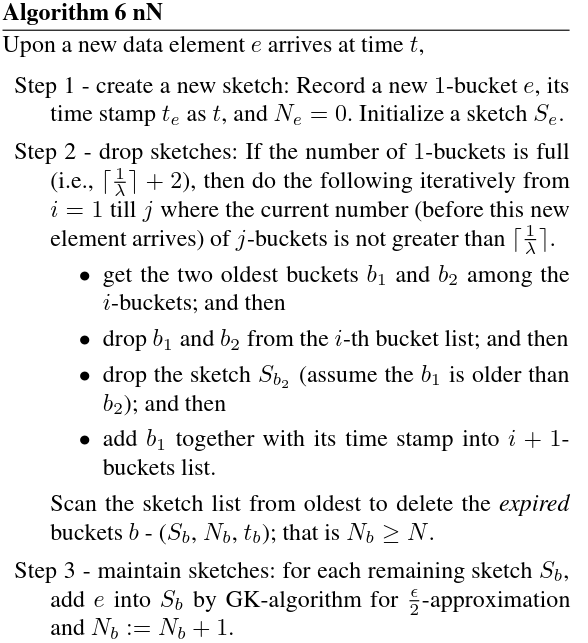

**Querying Quantiles**

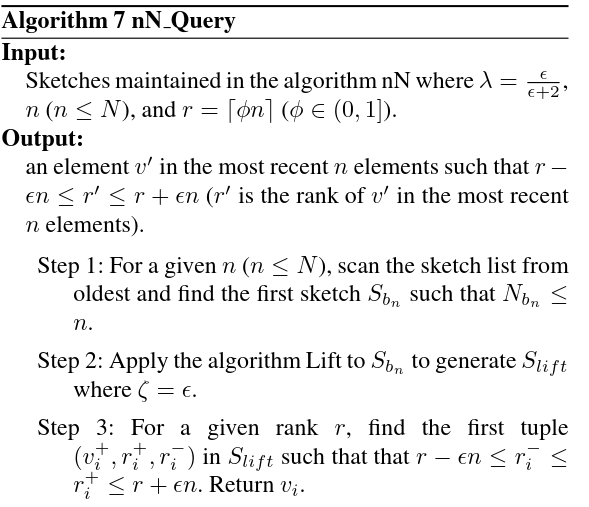

In following implementation of `query()` method, whilee step 1 is the same as it is in the paper, step 2 and 3 are replaced by using provided method in `GKArray`.

### Helper: GK sketch

Following implementation of GK Array is taken from [ddsketch on github](https://github.com/DataDog/sketches-py/blob/v0.1/gkarray/gkarray.py)

In [17]:
# https://github.com/DataDog/sketches-py/blob/v0.1/gkarray/gkarray.py

import numpy as np

DEFAULT_EPS = 0.01

class UnequalEpsilonException(Exception):
    pass

class Entry(object):

    def __init__(self, val, g, delta):
        self.val = val
        self.g = g
        self.delta = delta

    def __repr__(self):
        return 'Entry(val={}, g={}, delta={})'.format(self.val, self.g, self.delta)

class GKArray(object):

    def __init__(self, eps=None):
        if eps is None or eps <= 0 or eps >= 1:
            self.eps = DEFAULT_EPS
        else:
            self.eps = eps
        self.entries = []
        self.incoming = []
        self._min = float('+inf')
        self._max = float('-inf')
        self._count = 0
        self._sum = 0

    def size(self):
        if len(self.incoming) > 0:
            self.merge_compress()
        return len(self.entries)

    def add(self, val):
        """ Add a value to the sketch.
        """
        self.incoming.append(val)
        self._count += 1
        self._sum += val
        if val < self._min:
            self._min = val
        if val > self._max:
            self._max = val
        if self._count % (int(1.0/self.eps) + 1) == 0:
            self.merge_compress()

    def merge_compress(self, entries=[]):
        """ Merge the given entry list into self.entries as well as compressing any values in
        self.incoming buffer.
        Parameters:
            entries: list of Entry
        """
        removal_threshold = np.floor(2.0*self.eps*(self._count - 1))
        incoming = [Entry(val, 1, 0) for val in self.incoming] + [Entry(e.val, e.g, e.delta) for e in entries]
        incoming = sorted(incoming, key=lambda x: x.val)

        merged = []
        i, j = 0, 0
        while i < len(incoming) or j < len(self.entries):
            if i == len(incoming):
                # done with incoming; now only considering entries
                if j + 1 < len(self.entries) and\
                   self.entries[j].g + self.entries[j+1].g + self.entries[j+1].delta <= removal_threshold:
                    self.entries[j+1].g += self.entries[j].g
                else:
                    merged.append(self.entries[j])
                j += 1
            elif j == len(self.entries):
                # done with entries; now only considering incoming
                if i+1 < len(incoming) and\
                   incoming[i].g + incoming[i+1].g + incoming[i+1].delta <= removal_threshold:
                    incoming[i+1].g += incoming[i].g
                else:
                    merged.append(incoming[i])
                i += 1
            elif incoming[i].val < self.entries[j].val:
                if incoming[i].g + self.entries[j].g + self.entries[j].delta <= removal_threshold:
                    self.entries[j].g += incoming[i].g
                else:
                    incoming[i].delta = self.entries[j].g + self.entries[j].delta - incoming[i].g
                    merged.append(incoming[i])
                i += 1
            else:
                if j + 1 < len(self.entries) and\
                   self.entries[j].g + self.entries[j+1].g + self.entries[j+1].delta <= removal_threshold:
                    self.entries[j+1].g += self.entries[j].g
                else:
                    merged.append(self.entries[j])
                j += 1

        self.entries = merged
        self.incoming = []

    def merge(self, sketch):
        """ Merge another GKArray into the current. The two sketches should have the same
        epsilon value.
        Parameters:
            other: GKArray
        """
        if self.eps != sketch.eps:
            raise UnequalEpsilonException("Cannot merge two GKArrays with different epsilon values")

        if sketch._count == 0:
            return

        if self._count == 0:
            self.entries = [Entry(e.val, e.g, e.delta) for e in sketch.entries]
            self.incoming = sketch.incoming[:]
            self._min = sketch._min
            self._max = sketch._max
            self._count = sketch._count
            self._sum = sketch._sum
            return

        entries = []
        spread = int(sketch.eps*(sketch._count - 1))
        sketch.merge_compress()
        g = sketch.entries[0].g + sketch.entries[0].delta - spread - 1
        if g > 0:
            entries.append(Entry(sketch._min, g, 0))
        for i in range(len(sketch.entries)-1):
            g = sketch.entries[i+1].g + sketch.entries[i+1].delta - sketch.entries[i].delta
            if g > 0:
                entries.append(Entry(sketch.entries[i].val, g, 0))
        g = spread + 1 - sketch.entries[len(sketch.entries) - 1].delta
        if g > 0:
            entries.append(Entry(sketch.entries[len(sketch.entries) - 1].val, g, 0))

        self._count += sketch._count
        self._sum += sketch._sum
        self._min = min(self._min, sketch._min)
        self._max = max(self._max, sketch._max)

        self.merge_compress(entries)

    def quantile(self, q):
        """ Return an epsilon-approximate element at quantile q.
        Parameters:
            q: quantile to query for
               0 <= q <= 1
        """
        if q < 0 or q > 1 or self._count == 0:
            return np.nan

        if len(self.incoming) > 0:
            self.merge_compress()

        rank = int(q*(self._count - 1) + 1)
        spread = int(self.eps*(self._count - 1))
        g_sum = 0.0
        i = 0
        while i < len(self.entries):
            g_sum += self.entries[i].g
            if g_sum + self.entries[i].delta > rank + spread:
                    break
            i += 1
        if i == 0:
            return self._min

        return self.entries[i-1].val


### Lin n-of-N

In [27]:
import math

class LinnN:
  def __init__(self, N, e):
    self.N = N
    self.e = e
    self.lamda = e / (e + 2)
    self.buckets = [[]]
    self.max = int(math.ceil(1/self.lamda)) + 1

  def add(self, val):
    # Step 1: Create new bucket: [new_sketch, new_N]
    new_sketch = GKArray(self.e / 2)
    new_N = 0
    new_bucket = [new_sketch, new_N]
    self.buckets[0].append(new_bucket)

    # Step 2: Merge and drop buckets
    for i in range(0, len(self.buckets)):
      if len(self.buckets[i]) > self.max:
        b1 = self.buckets[i].pop(0)
        self.buckets[i].pop(0)
        if (i == len(self.buckets) - 1):
          self.buckets.append([b1])
        else:
          self.buckets[i+1].append(b1)
    if self.buckets[-1][0][1] >= self.N:
      self.buckets[-1].pop(0)

    # Step 3: Update sketch, n for N for every bucket
    for buckets in self.buckets:
      for b in buckets:
        b[0].add(val)
        b[1] += 1
  
  def query(self, n, quantile):
    # Scan sketch list from oldest to find 1st Sbn s.t Nbn <= n
    i = len(self.buckets) - 1
    j = 0
    found = False
    while i >= 0 and not found:
      buckets = self.buckets[i]
      j = 0
      while j < len(buckets) and buckets[j][1] > n:
        j += 1
      if j < len(buckets):
        found = True
      i -= 1
    Sbn = self.buckets[i][j][0]

    return Sbn.quantile(quantile)

## Simulate data and run implementation

In [36]:
import scipy.stats as stats

mu = 165           #sample mean
sigma = 15         #sample standard deviation
height = stats.norm(mu, sigma)

def make_sample(n=100):
    sample = height.rvs(n)
    return sample

SAMPLE_SIZE = 10**3
N = 8*10**3
PRECISION = 0.05

# Populate samples
sample = make_sample(SAMPLE_SIZE)

# Build buckets
linnN = LinnN(N, PRECISION)
for s in sample:
  linnN.add(s)

# Calculate 0.5-quantile
q = 0.5
n = N // 2
estm = linnN.query(n, q)
real = np.quantile(sample[-n:], q)
per_error = abs(estm - real) / real
print(f'Estimate: {estm} \nReal: {real} \nPercentage error: {per_error}')

Estimate: 165.35731129886003 
Real: 165.520331627367 
Percentage error: 0.0009848960964745938


## Plot graphs of time and space consumption

### Space consumption

**Authors' graph**
- `SAMPLE_SIZE = 1000K`
- `N = 100K to 1000K`

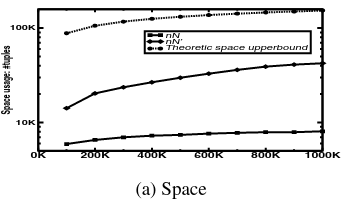

**Our graph**
- `SAMPLE_SIZE = 1000`
- `N = 200, 400, 600, 800, 1000`

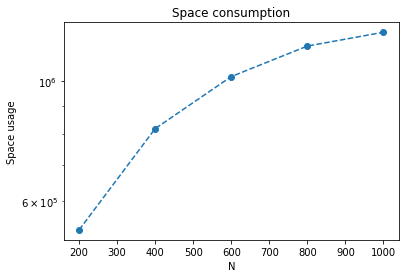

In [59]:
import tracemalloc
import matplotlib.pyplot as plt

SAMPLE_SIZE = 1000
PRECISION = 0.05

sample = make_sample(SAMPLE_SIZE)

Ns = [200, 400, 600, 800, 1000]
mem = []

for N in Ns:
  tracemalloc.start()
  linnN = LinnN(N, PRECISION)
  for s in sample:
    linnN.add(s)
  mem.append(tracemalloc.get_traced_memory()[1])
  tracemalloc.stop()

plt.semilogy(Ns, mem, linestyle='--', marker='o')
plt.xlabel("N")
plt.ylabel("Space usage")
plt.title("Space consumption")
plt.show()

### Query performance

**Authors' graph**
- `SAMPLE_SIZE = 1000K`
- `N = 800K`
- `20K queries`

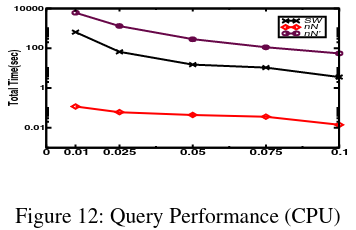

**Our graph**
- `SAMPLE_SIZE = 1000`
- `N = 800`
- `e = 0.01, 0.025, 0.05, 0.075, 0.1`
- One query: `0.5-quantile`, `n = 400`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


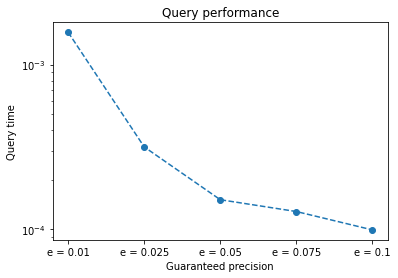

In [62]:
import tracemalloc
import matplotlib.pyplot as plt
import time

time_start = time.clock()
#run your code
time_elapsed = (time.clock() - time_start)

SAMPLE_SIZE = 1000
N = 800

sample = make_sample(SAMPLE_SIZE)

es = [0.01, 0.025, 0.05, 0.075, 0.1]
total_time = []

for e in es:
  # Build buckets
  linnN = LinnN(N, e)
  for s in sample:
    linnN.add(s)

  # Query
  time_start = time.clock()
  q = 0.5
  n = N // 2
  linnN.query(n, q)
  total_time.append(time.clock() - time_start)

plt.semilogy([f'e = {e}' for e in es], total_time, linestyle='--', marker='o')
plt.xlabel("Guaranteed precision")
plt.ylabel("Query time")
plt.title("Query performance")
plt.show()

**General trends of those two graphs are in line with the paper**